In [132]:
import pandas as pd
import io

import tweepy
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
from textblob import TextBlob
import nltk
from google.colab import files
import csv
from urllib.request import urlopen
from bs4 import BeautifulSoup
from google.colab import files
import requests
import os
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
import matplotlib.pyplot as plt
import string
#sentiment analysis package
#!pip install textblob
from textblob import TextBlob
from collections import defaultdict

#general text pre-processor
#!pip install nltk

#tweet pre-processor 
#!pip install tweet-preprocessor
import preprocessor as p
#!pip install twint
#import twint 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
os.environ['TWITTER_API_KEY'] = 'U75HhTxzqdxzwox2NyjvgO7hZ'
os.environ['TWITTER_API_SECRET']= '9qRB7q4iSKp3zlK8khqnYAxFOVutTj2HbALDGJPePzMxgepWYa'
os.environ['TWITTER_ACCESS_TOKEN'] = '2970824841-ZAcPytgG04eav6UwGneW6q6sjUOmfRRRS0BYmBJ'
os.environ['TWITTER_ACCESS_TOKEN_SECRET'] = '7lbijJgb23tJPtnyeLc32D1vXKPWemE1OPjB36L5jyM6z'

In [73]:
def get_elements(url, tag='',search={}, fname=None):
    """
    Downloads a page specified by the url parameter
    and returns a list of strings, one per tag element
    """
    if isinstance(url,str):
        response = requests.get(url)
    else:
        #if already it is a loaded html page
        response = url
    if response is not None:
        html = BeautifulSoup(response.text, 'html.parser')
        res = []
        if tag:    
            for li in html.select(tag):
                for name in li.text.split('\n'):
                    if len(name) > 0:
                        res.append(name.strip())
        if search:
            soup = html            
            r = ''
            if 'find' in search.keys():
                print('finding',search['find'])
                soup = soup.find(**search['find'])
                r = soup
            if 'find_all' in search.keys():
                print('finding all of',search['find_all'])
                r = soup.find_all(**search['find_all'])
        
        return r
def scrape(url):
	r = requests.get(url)
	soup = BeautifulSoup(r.content , features="html.parser")
	return soup
def init(): 
    global api
    consumer_key = os.environ.get('TWITTER_API_KEY')
    consumer_secret = os.environ.get('TWITTER_API_SECRET')
    access_key = os.environ.get('TWITTER_ACCESS_TOKEN')
    access_secret = os.environ.get('TWITTER_ACCESS_TOKEN_SECRET')
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_key, access_secret)
    api=tweepy.API(auth , wait_on_rate_limit=True)
    return api
def get_mention_count(user):

    c = twint.Config()
    c.since = "2020-06-19"
    c.until = "2020-07-19"
    c.Search = '@' + user
    c.Store_object = True

    twint.run.Search(c)
    tweets = twint.output.tweets_list
    mention_count = len(tweets)
    tweets.clear()

    return mention_count
class tweetsearch():
    '''
    This is a basic class to search and download twitter data.
    You can build up on it to extend the functionalities for more 
    sophisticated analysis
    '''
    def __init__(self, cols=None,auth=None):
        #
        if not cols is None:
            self.cols = cols
        else:
            self.cols = ['id', 'created_at', 'source', 'original_text','clean_text', 
                    'sentiment','polarity','subjectivity', 'lang',
                    'favorite_count', 'retweet_count', 'original_author',   
                    'possibly_sensitive', 'hashtags',
                    'user_mentions', 'place', 'place_coord_boundaries']
            
        if auth is None:
            
            #Variables that contains the user credentials to access Twitter API 
            consumer_key = os.environ.get('TWITTER_API_KEY')
            consumer_secret = os.environ.get('TWITTER_API_SECRET')
            access_token = os.environ.get('TWITTER_ACCESS_TOKEN')
            access_token_secret = os.environ.get('TWITTER_ACCESS_TOKEN_SECRET')
            


            #This handles Twitter authetification and the connection to Twitter Streaming API
            auth = OAuthHandler(consumer_key, consumer_secret)
            auth.set_access_token(access_token, access_token_secret)
            

        #            
        self.auth = auth
        self.api = tweepy.API(auth , wait_on_rate_limit=True , wait_on_rate_limit_notify=True) 
        self.filtered_tweet = ''
            

    def clean_tweets(self, twitter_text):

        #use pre processor
        tweet = p.clean(twitter_text)

         #HappyEmoticons
        emoticons_happy = set([
            ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
            ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
            '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
            'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
            '<3'
            ])

        # Sad Emoticons
        emoticons_sad = set([
            ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
            ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
            ':c', ':{', '>:\\', ';('
            ])

        #Emoji patterns
        emoji_pattern = re.compile("["
                 u"\U0001F600-\U0001F64F"  # emoticons
                 u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                 u"\U0001F680-\U0001F6FF"  # transport & map symbols
                 u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                 u"\U00002702-\U000027B0"
                 u"\U000024C2-\U0001F251"
                 "]+", flags=re.UNICODE)

        #combine sad and happy emoticons
        emoticons = emoticons_happy.union(emoticons_sad)

        stop_words = set(stopwords.words('english'))
        word_tokens = nltk.word_tokenize(tweet)
        #after tweepy preprocessing the colon symbol left remain after      
        #removing mentions
        tweet = re.sub(r':', '', tweet)
        tweet = re.sub(r'‚Ä¶', '', tweet)

        #replace consecutive non-ASCII characters with a space
        tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)

        #remove emojis from tweet
        tweet = emoji_pattern.sub(r'', tweet)

        #filter using NLTK library append it to a string
        filtered_tweet = [w for w in word_tokens if not w in stop_words]

        #looping through conditions
        filtered_tweet = []    
        for w in word_tokens:
        #check tokens against stop words , emoticons and punctuations
            if w not in stop_words and w not in emoticons and w not in string.punctuation:
                filtered_tweet.append(w)

        return ' '.join(filtered_tweet)            

    def get_tweets(self, keyword, csvfile=None):
        
        
        df = pd.DataFrame(columns=self.cols)
        
        if not csvfile is None:
            #If the file exists, then read the existing data from the CSV file.
            if os.path.exists(csvfile):
                df = pd.read_csv(csvfile, header=0)
            

        #page attribute in tweepy.cursor and iteration
        for page in tweepy.Cursor(self.api.search, q=keyword,count=200, include_rts=False).pages():

            # the you receive from the Twitter API is in a JSON format and has quite an amount of information attached
            for status in page:
                
                new_entry = []
                status = status._json
                
                #filter by language
                if status['lang'] != 'en':
                    continue

                
                #if this tweet is a retweet update retweet count
                if status['created_at'] in df['created_at'].values:
                    i = df.loc[df['created_at'] == status['created_at']].index[0]
                    #
                    cond1 = status['favorite_count'] != df.at[i, 'favorite_count']
                    cond2 = status['retweet_count'] != df.at[i, 'retweet_count']
                    if cond1 or cond2:
                        df.at[i, 'favorite_count'] = status['favorite_count']
                        df.at[i, 'retweet_count'] = status['retweet_count']
                    continue

                #calculate sentiment
                filtered_tweet = self.clean_tweets(status['text'])
                blob = TextBlob(filtered_tweet)
                Sentiment = blob.sentiment     
                polarity = Sentiment.polarity
                subjectivity = Sentiment.subjectivity

                new_entry += [status['id'], status['created_at'],
                              status['source'], status['text'], filtered_tweet, 
                              Sentiment,polarity,subjectivity, status['lang'],
                              status['favorite_count'], status['retweet_count']]

                new_entry.append(status['user']['screen_name'])

                try:
                    is_sensitive = status['possibly_sensitive']
                except KeyError:
                    is_sensitive = None

                new_entry.append(is_sensitive)

                hashtags = ", ".join([hashtag_item['text'] for hashtag_item in status['entities']['hashtags']])
                new_entry.append(hashtags) #append the hashtags

                #
                mentions = ", ".join([mention['screen_name'] for mention in status['entities']['user_mentions']])
                new_entry.append(mentions) #append the user mentions

                try:
                    xyz = status['place']['bounding_box']['coordinates']
                    coordinates = [coord for loc in xyz for coord in loc]
                except TypeError:
                    coordinates = None
                #
                new_entry.append(coordinates)

                try:
                    location = status['user']['location']
                except TypeError:
                    location = ''
                #
                new_entry.append(location)

                #now append a row to the dataframe
                single_tweet_df = pd.DataFrame([new_entry], columns=self.cols)
                df = df.append(single_tweet_df, ignore_index=True)

        if not csvfile is None:
            #save it to file
            df.to_csv(csvfile, columns=self.cols, index=False, encoding="utf-8")
            
        return df

In [49]:
#getting the africa leaders
url = "https://www.atlanticcouncil.org/blogs/africasource/african-leaders-respond-to-coronavirus-on-twitter/"
res_gov = get_elements(url, search={'find_all':{'class_':'wp-block-embed__wrapper'}}) 
res_gv = get_elements(url, search={'find_all':{'class_':'twitter-tweet'}})
officials = []
for i in range(2 ,len(res_gv)):
    mainblk = res_gv[i]
    olist = mainblk.find_all(text=True , recursive=False)
    officials.append(olist)
final = []
for item in officials:
    final.append(item[0])

finallist = pd.DataFrame(final, columns=['User'])
top10 = finallist.head(10)
leaders =  []
##clean up the list items
for index, row in finallist.iterrows():
  namentag = row['User']
  tag =  str(namentag).split('@', 1)[1].split(')')[0]
  leaders.append(tag)
leaders
#df1 -> leaders handles
df1 = pd.DataFrame(leaders , columns = ['Tags'])
df1.to_csv("all_leaders.csv" , index= False)


finding all of {'class_': 'wp-block-embed__wrapper'}
finding all of {'class_': 'twitter-tweet'}


In [57]:
#getting africa freak data 
url = "https://africafreak.com/100-most-influential-twitter-users-in-africa"
influencers = scrape(url)
names = influencers.findAll("h2")
fulllist = []
for name in names:
    thisname = name.text
    namenno = thisname.split(".")
    fulllist.append(namenno)
#fulllist: the fulllist includes unnecessary columns that we proceed to isolate
##turn the list into a Dataframe and select column by by index
###drop the unnecessary rows
infltags = pd.DataFrame(fulllist)
ftags = infltags.iloc[:, [1]]
ftags.tail()
ftags,last_rows=ftags.drop(ftags.tail(5).index),ftags.tail(1)
# ftags: final tags of influencers and their names ; last_rows: discarded bottom rows
#list to store all the filtered tags
##########come back and make this a function bc it is repetitive
influencernamentags = []

for index, row in ftags.iterrows():
    influencernamentags.append(row[1])

finaltags = []
char1 = '@'
char2 = ')'
for name in influencernamentags:
      text =  name[name.find(char1)+1 : name.find(char2)]
      finaltags.append(text)
#convert list to dataframe
influencers_df = pd.DataFrame (finaltags,columns=['Handle'])
####Influencers_df --> df with influencer tags
pd.set_option("display.max.columns", None)

,Handle
0,gettleman
1,a24media
2,andiMakinana
3,AfricaCheck
4,JamesCopnall
...,...
95,Julius_S_Malema
96,News24
97,Jacob
98,GarethCliff


In [61]:
#combine the dataframes
frames = [influencers_df["Handle"] , df1["Tags"]]
#all_tags---> contains all the tags 
alltags = pd.concat(frames)
all_tags = alltags.to_frame()

In [62]:
tweep = init()
#write  influencer stats to csv file
csvFile = open('influencertweetstats.csv', 'a')
csvWriter = csv.writer(csvFile)
csvWriter.writerow(["ScreenName", "FollowersCount", "FavoritesCount"  ,"FriendsCount" , "TweetsCount" , "Status Count"])

for item , rows in all_tags.iterrows():
    try:
       userfollowers = tweep.get_user(rows[0] ,include_entities=1)
    except tweepy.error.TweepError as t:
      pass
        # if t.response['code'] == 50:
        #   pass
    csvWriter.writerow([userfollowers.screen_name, userfollowers.followers_count, userfollowers.favourites_count ,  userfollowers.friends_count, userfollowers.listed_count , userfollowers.statuses_count ])
#files.download('afritweetstats.csv')
csvFile.close()

Using the csv files , we proceed to extract the users tweet information 

In [64]:
reader = csv.reader(open("influencertweetstats.csv"))
full_list = pd.DataFrame(reader)
#set header
new_header = full_list.iloc[0]
full_list.columns = new_header 
full_list = full_list.iloc[1:]
#get the reach
full_list["FollowersCount"] = pd.to_numeric(full_list["FollowersCount"] , errors='coerce')
full_list["FriendsCount"] = pd.to_numeric(full_list["FriendsCount"], errors='coerce')
full_list["ReachCount"] = full_list["FollowersCount"] - full_list["FriendsCount"]


,ScreenName,FollowersCount,FavoritesCount,FriendsCount,TweetsCount,Status Count,ReachCount
1,gettleman,25705.0,10,37.0,718,3773,25668.0
2,a24media,31283.0,1623,3059.0,634,16870,28224.0
3,AndiMakinana,101287.0,9027,2839.0,269,142236,98448.0
4,AfricaCheck,68073.0,3916,4592.0,952,27332,63481.0
5,JamesCopnall,21965.0,3626,5049.0,584,19439,16916.0
...,...,...,...,...,...,...,...
260,IssoufouMhm,116386.0,3,17.0,146,349,116369.0
261,MBuhari,3273561.0,8,26.0,1649,4735,3273535.0
262,Macky_Sall,1376464.0,530,171.0,692,2796,1376293.0
263,PresidentBio,15000.0,0,0.0,33,83,15000.0


In [76]:
#scarpe get existing users t
ts = tweetsearch()
for item , row in full_list.iterrows():
  #print(row.ScreenName)
  try:
    df = ts.get_tweets(row.ScreenName, csvfile=row.ScreenName+".csv")
  except tweepy.TweepError:
    pass

KeyboardInterrupt: ignored

In [1]:
#get the sum of retweets and likes for all tweets and add the popularity score to the dataframe
rtcount = []
likecount = []
unique_names = full_list['ScreenName'].unique()
unique_df = pd.DataFrame(unique_names)
namedata = []

tags = []
for items , row in unique_df.iterrows():
  csvfile = str(row[0]) +'.csv'
  try:
    with open(csvfile) as f:
      rows = csv.DictReader(f)
      totretweets = sum(float(r['retweet_count']) for r in rows)
      totlikes = sum(float(r['favorite_count']) for r in rows)
      column_names = rows.fieldnames
      name = row[0]
      namedata.append(name)
      rtcount.append(totretweets)
      likecount.append(totlikes)
  except IOError:
    pass
  try:
    nlist = pd.read_csv(csvfile)
    tags.append(nlist.hashtags)
  except Exception:
    pass
dftags = pd.DataFrame(tags)
pop_df = pd.DataFrame(list(zip(namedata, rtcount , likecount)), 
               columns =['ScreenName', 'Retweets' , 'Likes'])
dfinal = pd.merge(full_list,pop_df, on = "ScreenName",how='inner')
dfinal.drop_duplicates('ScreenName', inplace = True) 
dfinal = dfinal.append()
dftags

NameError: ignored

In [ ]:
#get top 5 hashtags for each user

Bring in the plots of the Reach and the Popularity

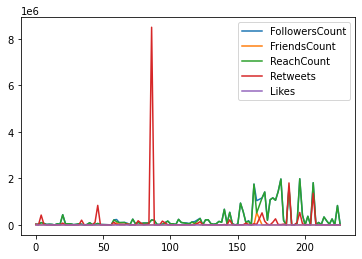

In [131]:
trend = dfinal.plot()
trend.title ="Trend in Popularity , Reach and Relevance"

# References
1. Yanofsky David, tweet_dumper.py, (2013), GistHub repository, https://gist.github.com/yanofsky/5436496
2.https://towardsdatascience.com/analyzing-twitter-relationships-in-python-without-an-api-a35b5b502cb
